In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal
import pandas as pd
from types import SimpleNamespace

# !pip install pint
from pint import UnitRegistry
units = UnitRegistry(system = "mks")
units.default_format = "~P.2e"

Solenoid value (0-255)
0.0    509.98
1.0    509.99
2.0    509.99
3.0    509.99
4.0    509.99
Name: Hall analog (raw), dtype: float64


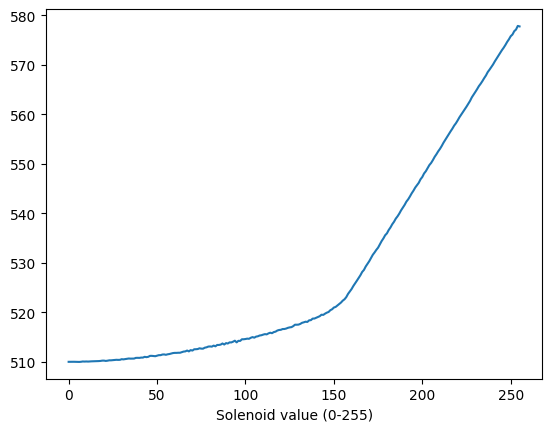

In [3]:
sensor_data = pd.read_csv("step_ramp_1sSteps.csv")
# sensor_data = sensor_data.truncate(before=400, after=5550)
sensor_data.drop(sensor_data.columns[3], axis=1, inplace=True)

# Drop rows with NaN values in "solenoid_commanded" column
df_short_solenoid = sensor_data['Solenoid value (0-255)'].dropna()
# Drop rows with NaN values in "analog value (1-1024) (raw)" column
df_short_analog = sensor_data['Hall analog (raw)'].dropna()
df_short_analog.index = df_short_solenoid.index
# Merge the shortened DataFrames based on the index
df_shortened = pd.concat([df_short_solenoid, df_short_analog],axis=1)

# Group by "solenoid_commanded" and calculate the average of "analog value (1-1024) (raw)"
average_values = df_shortened.groupby('Solenoid value (0-255)')['Hall analog (raw)'].mean()
average_values.plot()
# sensor_data.drop(sensor_data.columns[0], axis=1, inplace=True)

# if interpolating
# sensor_data = sensor_data.interpolate()

# if droppi"analog value (1-1024) (raw)"ng na values and collapsing
# sensor_data["analog value (1-1024) (raw)"] = sensor_data["analog value (1-1024) (raw)"][sensor_data["analog value (1-1024) (raw)"].notna()]
# sensor_data["solenoid_commanded"] = sensor_data["solenoid_commanded"][sensor_data["solenoid_commanded"].notna()]

# mean_window = 50
# sensor_data["analog average"] = sensor_data["analog value (1-1024) (raw)"].rolling(mean_window).mean().shift(-mean_window//2)
# sensor_data.dropna(inplace = True)

# sensor_data.plot()
# sensor_data.plot(x="solenoid_commanded", y="analog value (1-1024) (raw)")
# sensor_data.plot(x="solenoid_commanded", y="analog average")
pd.options.display.max_rows = 4000
print(average_values.head())

   timestamp(ms)  Hall analog (raw)  Solenoid value (0-255)
0          0.000              510.0                     NaN
1          0.003                NaN                     0.0
2          0.005              510.0                     NaN
3          0.007                NaN                     0.0
4          0.009              510.0                     NaN
   Solenoid value (0-255)  Hall analog (raw)
1                     0.0              510.0
3                     0.0              510.0
5                     0.0              510.0
7                     0.0              510.0
9                     0.0              510.0
Linear regression between 155 and 255: slope = 0.5669, intercept = 434
Linear regression between 50 and 155: slope = 0.0947, intercept = 506


Text(0, 0.5, 'Hall effect sensor reading (0-1023)')

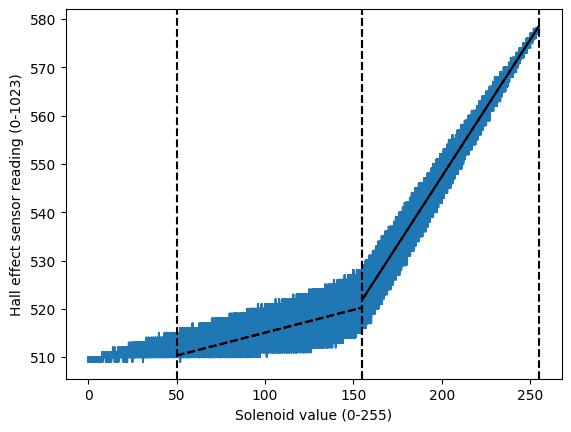

In [9]:
class LinearRegressionRegion():
    def __init__(self, x_series, y_series, start, end):
        self.x_series = x_series
        self.y_series = y_series
        self.start = start
        self.end = end
        self.range = (self.start <= self.x_series) & (self.x_series <= self.end) & self.x_series.notnull()

        # linear regression
        A = np.vstack([self.x_series[self.range], np.ones(len(self.x_series[self.range]))]).T
        self.slope, self.intercept = np.linalg.lstsq(A, self.y_series[self.range], rcond=None)[0]
        self.print_values()

    def plot(self):
        plt.axvline(x = self.start, color = "black", linestyle = "dashed")
        plt.axvline(x = self.end, color = "black", linestyle = "dashed")
        plt.plot(self.x_series[self.range], self.x_series[self.range] * self.slope + self.intercept, color = "black", linestyle = "dashed")

    def print_values(self):
        print(f"Linear regression between {self.start} and {self.end}: slope = {self.slope:.4f}, intercept = {self.intercept:.0f}")

print(sensor_data.head())
print(df_shortened.head())
plt.plot(df_shortened["Solenoid value (0-255)"], df_shortened["Hall analog (raw)"])
region_1 = LinearRegressionRegion(df_shortened["Solenoid value (0-255)"], df_shortened["Hall analog (raw)"], start = 155, end = 255)
region_1.plot()
region_2 = LinearRegressionRegion(df_shortened["Solenoid value (0-255)"], df_shortened["Hall analog (raw)"], start = 50, end = 155)
region_2.plot()
plt.xlabel("Solenoid value (0-255)")
plt.ylabel("Hall effect sensor reading (0-1023)")

Linear regression between 155 and 255: slope = -0.8932, intercept = 904
Linear regression between 50 and 155: slope = -0.8255, intercept = 893


Text(0, 0.5, 'Hall effect sensor reading (0-1023)')

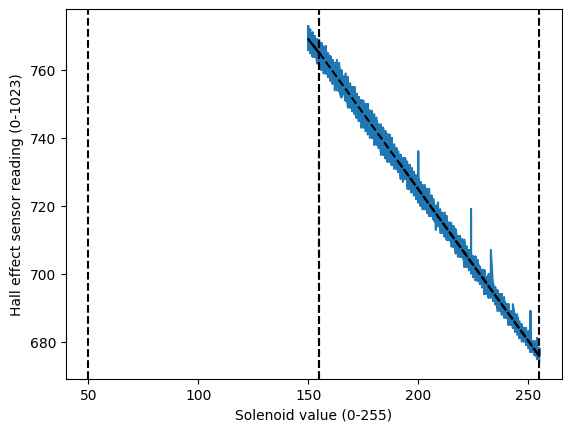

In [10]:
teensy_sensor_data = pd.read_csv("analog_read_vs_solenoid_pwm_teensy.csv")
plt.plot(teensy_sensor_data["analogWrite"], teensy_sensor_data["sensorVal"])
region_1 = LinearRegressionRegion(teensy_sensor_data["analogWrite"], teensy_sensor_data["sensorVal"], start = 155, end = 255)
region_1.plot()
region_2 = LinearRegressionRegion(teensy_sensor_data["analogWrite"], teensy_sensor_data["sensorVal"], start = 50, end = 155)
region_2.plot()
plt.xlabel("Solenoid value (0-255)")
plt.ylabel("Hall effect sensor reading (0-1023)")